In [2]:
import numpy as np
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from copy import deepcopy
from utilities import *
from matplotlib import rcParams
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 8,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True, 
    'legend.title_fontsize': 8}
# tell matplotlib about your params
rcParams.update(params)

# set nice figure sizes
fig_width_pt = 487.8225/2.3 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*0.9#*ratio  # height in inches
fig_size = [fig_width,2*0.9*fig_width]
rcParams.update({'figure.figsize': fig_size})

In [4]:
sns.set_context("paper")

# Plotting the vector field

In [4]:
X, Y = np.meshgrid(np.arange(-1.5, 1.5, .15), np.arange(-1, 1, .15))

U = -0.05*X + Y
V = -X - 0.05*Y 

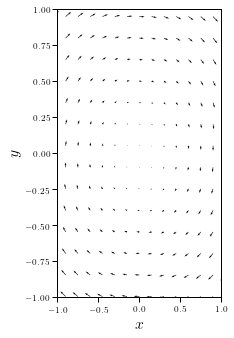

In [5]:
plt.figure()
plt.quiver(X, Y, U, V, units='width', edgecolor='k')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel(r"$x$",fontsize=16)
plt.ylabel(r"$y$",fontsize=16)
plt.show()

# Solve IVP with RK45

In [6]:
A = np.array([
    [-0.05, 1.],
    [-1., -0.05]
])
x0 = np.array([1,0])

In [7]:
f = lambda t,x: np.dot(A,x)

In [8]:
T = 40
t = np.linspace(0, T, 500)

In [9]:
sol = solve_ivp(f, (0,T), x0, t_eval = t, method='RK45')

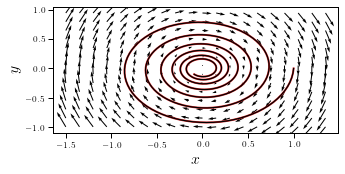

In [13]:
plt.figure()
plt.quiver(X, Y, U, V, units='width', edgecolor='k')
plt.plot(sol.y[0],sol.y[1], color="tab:red", linewidth=2.)
plt.plot(np.exp(-t/20)*np.cos(t), -1.0*np.exp(-t/20)*np.sin(t),'k')
plt.xlabel(r"$x$",fontsize=16)
plt.ylabel(r"$y$",fontsize=16)
plt.show()

# Using neural ODEs to learn a dynamical system

In [10]:
true_x0 = torch.tensor([[1., 0.]])
t = torch.linspace(0., T, 500)
true_A = torch.tensor([[-0.05, 1.0], [-1.0, -0.05]]).T

Define right-hand side of ODE

In [11]:
class Lambda(nn.Module):

    def forward(self, t, y):
        
        return torch.mm(y, true_A)

Define neural ODE

In [74]:
class ODE_func(nn.Module):

    def __init__(self):
        super(ODE_func, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2, 10),
            nn.Tanh(),
            nn.Linear(10, 2),
        )

        #for m in self.net.modules():
        #   if isinstance(m, nn.Linear):
        #        nn.init.normal_(m.weight, mean=0, std=0.1)
        #        nn.init.constant_(m.bias, val=0)

    def forward(self, t, y):
        return self.net(y)

Generate batches based on observed trajectory

In [75]:
def get_batch():
    s = torch.from_numpy(np.random.choice(np.arange(data_size - batch_time, dtype=np.int64), batch_size, replace=False))
    batch_x0 = true_x[s]  # (M, D)
    batch_t = t[:batch_time]  # (T)
    batch_x = torch.stack([true_x[s + i] for i in range(batch_time)], dim=0)  # (T, M, D)
    return batch_x0, batch_t, batch_x

In [76]:
true_x = odeint(Lambda(), true_x0, t, method='dopri5')

In [77]:
data_size = 500
batch_size = 10
batch_time = 10

torch.manual_seed(123)
np.random.seed(123)

func = ODE_func()
optimizer = optim.Adam(func.parameters(), lr=1e-2)
batch_x0, batch_t, batch_x = get_batch()    
loss_arr_BP = []

best_params_BP = 0
best_loss = 1e9

start = time.time()

itr = 0
end = start

while (end-start) <= 60:
    
    optimizer.zero_grad()
    pred_x = odeint(func, batch_x0, batch_t, method='dopri5')
    loss = torch.mean((pred_x - batch_x)**2)
    loss_arr_BP.append(loss.clone().detach())
    loss.backward()
    optimizer.step()

    if loss < best_loss:
        best_loss = loss
        best_params_BP = deepcopy(func.state_dict())
                       
    end = time.time()
    
    if itr % 100 == 0:
        print(itr,end-start)
        
    itr += 1

1000 28.815268516540527


In [52]:
func.load_state_dict(best_params_BP)

<All keys matched successfully>

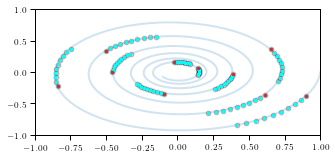

In [53]:
plt.figure()
pred_x = odeint(func, true_x0, t, method='dopri5')
plt.plot(pred_x.detach().numpy()[:, 0, 0],pred_x.detach().numpy()[:, 0, 1], linewidth=2., alpha = 0.2)

pred_x = odeint(func, batch_x0, batch_t, method='dopri5')
for i in range(batch_x.size()[1]):
    plt.plot(batch_x.detach().numpy()[:,i,0,0],batch_x.detach().numpy()[:,i,0,1], '.', color='aqua', zorder=10)
plt.plot(batch_x0.detach().numpy()[:,0,0],batch_x0.detach().numpy()[:,0,1], '.', color='tab:red', zorder=10)
for i in range(batch_x.size()[1]):
    plt.plot(pred_x.detach().numpy()[:,i,0,0],pred_x.detach().numpy()[:,i,0,1],'ko',alpha=0.2)
    
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()

In [56]:
pred_x = odeint(func, batch_x0, batch_t, method='dopri5')
1e6*torch.mean((pred_x - batch_x)**2)

tensor(1.0308, grad_fn=<MulBackward0>)

In [55]:
pred_x = odeint(func, true_x0, t, method='dopri5')
error = 1e3*torch.mean((pred_x - true_x)**2)
print(error)

tensor(1.1176, grad_fn=<MulBackward0>)


# EKI optimization of neural ODEs

In [16]:
# hyperparameters EKI
number_iterations = 40
new_ensemble_members = 10

In [42]:
best_params_EKI = []
loss_arr_EKI = []

torch.manual_seed(123)

ensemble_members = 22
gamma = 0.9
Gamma = torch.eye(batch_x.flatten().size()[0]) * gamma
y = batch_x.flatten().repeat(ensemble_members)
y = y.reshape(ensemble_members,-1)

best_loss = 1e9
best_params = 0
loss_arr = []

func_enkf = ODE_func()
nn_params = get_weights(func_enkf)

In [43]:
tensorlist_to_tensor(get_weights(func_enkf))

tensor([-0.2883,  0.0234, -0.3512,  0.2667, -0.6025,  0.5183, -0.5140, -0.5622,
        -0.4468,  0.3202, -0.2613,  0.2646, -0.6001, -0.4290, -0.2596, -0.1390,
        -0.5394,  0.4630, -0.1668,  0.2270,  0.5000,  0.1317,  0.1934,  0.6825,
        -0.3189,  0.2240, -0.3146,  0.5053,  0.5647, -0.6519,  0.2699,  0.1510,
         0.1378,  0.1302,  0.2629, -0.0418, -0.2674, -0.0907, -0.2227,  0.0209,
        -0.0590, -0.1696, -0.0288,  0.2996, -0.0249,  0.0100, -0.0493,  0.0497,
         0.2818,  0.1934,  0.1122,  0.0687])

In [44]:
u, G_u = generate_initial_ensemble(ODE_func, batch_x0, batch_t, ensemble_members, solve_oc_problem=False)

In [37]:
loss = torch.mean((G_u-y)**2,axis=1)
min_ind = torch.argmin(loss)
loss = float(loss[min_ind])
#loss = torch.mean(torch.mean((G_u-y)**2,axis=1))
#loss_arr_EKI.append(loss)

n = 0

start = time.time()
end = start

while (end-start) <= 60:
    u = update_step(u, G_u, y, Gamma, ensemble_members)

    G_u = compute_F_u(u, ODE_func, batch_x0, batch_t, ensemble_members, solve_oc_problem=False)

    loss = torch.mean((G_u-y)**2,axis=1)
    min_ind = torch.argmin(loss)
    loss = float(loss[min_ind])
    loss_arr_EKI.append(loss)
    #loss = torch.mean(torch.mean((G_u-y)**2,axis=1))
    #loss_arr_EKI.append(loss)

    if loss < best_loss:
        best_loss = loss
        best_params_EKI = u[min_ind]
    
    if n % 2 == 0:
        #print(n,loss)
        gamma = 0.9*np.exp(-0.35*n)
        Gamma = torch.eye(batch_x.flatten().size()[0]) * gamma
    
    #if n == 10:
    #    u, ensemble_members = add_new_ensemble_members(u, ODE_func, new_ensemble_members)
    #
    #    G_u = compute_F_u(u, ODE_func, batch_x0, batch_t, ensemble_members, solve_oc_problem=False)
    #
    #    y = batch_x.flatten().repeat(ensemble_members)
    #    y = y.reshape(ensemble_members,-1)
    
    #    gamma = 0.7
    #    Gamma = torch.eye(batch_x.flatten().size()[0]) * gamma
    n += 1
        
    end = time.time()
print(end - start)

60.37739610671997


In [38]:
best_params_EKI

tensor([-0.1250,  0.6977,  1.4883, -0.1355, -0.6282, -1.0199,  0.4379,  1.1310,
        -0.9116, -0.0515,  0.1880, -0.4531,  0.6531, -0.1780,  0.8167,  0.9362,
        -0.1261, -0.9223, -0.6416, -0.9694, -0.4632, -1.2950, -0.4530, -1.6335,
        -0.4110, -0.1246, -0.1478, -1.0095, -0.6451, -1.2871,  0.3123, -0.1560,
        -0.3678,  0.0921,  0.2671, -0.8309,  0.0891,  0.3589,  0.0504, -0.1873,
         0.6557, -0.1985,  0.6760, -0.2616,  0.4518, -0.1230,  0.0353, -0.4567,
        -0.6267,  0.2262,  0.0866, -0.1901])

In [39]:
updated_params = npvec_to_tensorlist(best_params_EKI,nn_params)
set_weights(func_enkf,updated_params)

In [51]:
pred_x = odeint(func_enkf, true_x0, t, method='dopri5')
error = 1e4*torch.mean((pred_x - true_x)**2)
print(error)

tensor(9.1075, grad_fn=<MulBackward0>)


In [41]:
pred_x = odeint(func_enkf, batch_x0, batch_t, method='dopri5')
torch.mean((pred_x - batch_x)**2)

tensor(4.8889e-07, grad_fn=<MeanBackward0>)

/home/lucasb/anaconda3/envs/inventory/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 


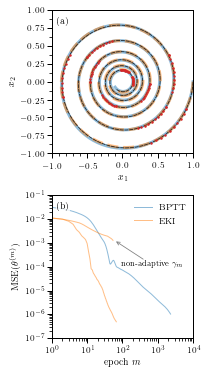

In [95]:
fig = plt.figure(constrained_layout=True)
fig.patch.set_facecolor('white')
mosaic = """
                A
                B
                """
ax_dict = fig.subplot_mosaic(mosaic)

text = ax_dict["A"].text(0.03*2-1,0.9*2-1,r"(a)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))
text = ax_dict["B"].text(1.3,0.024,r"(b)")
text.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='white', pad=0))

loss_arr_BP = np.loadtxt("data/loss_arr_BP_spiral.dat")
loss_arr_EKI_no_schedule = np.loadtxt("data/loss_arr_EKI_no_schedule_spiral.dat")
loss_arr_EKI = np.loadtxt("data/loss_arr_EKI_spiral.dat")
func.load_state_dict(torch.load("data/BP_spiral_model.pt"))
func_enkf.load_state_dict(torch.load("data/EKI_spiral_model.pt"))

pred_x = odeint(func, true_x0, t, method='dopri5')
ax_dict["A"].plot(pred_x.detach().numpy()[:, 0, 0],pred_x.detach().numpy()[:, 0, 1],linewidth=3.,alpha=0.5)

pred_x = odeint(func_enkf, true_x0, t, method='dopri5')
ax_dict["A"].plot(pred_x.detach().numpy()[:, 0, 0],pred_x.detach().numpy()[:, 0, 1],linewidth=3.,alpha=0.5,ls='--')

ax_dict["A"].plot(sol.y[0],sol.y[1],color="k",alpha=0.8,linewidth=0.8,linestyle=(0, (5, 1)))

for i in range(batch_x.size()[1]):
    ax_dict["A"].plot(batch_x.detach().numpy()[:,i,0,0],batch_x.detach().numpy()[:,i,0,1], '.',color='tab:red',alpha=0.9,markersize=3)
ax_dict["A"].plot(batch_x0.detach().numpy()[:,0,0],batch_x0.detach().numpy()[:,0,1], '.',color='tab:red',alpha=0.9,markersize=3)

ax_dict["B"].plot(loss_arr_BP,linewidth=1.,alpha=0.5,label=r"BPTT")
ax_dict["B"].plot(loss_arr_EKI,linewidth=1.,alpha=0.5,label=r"EKI")
ax_dict["B"].plot(loss_arr_EKI_no_schedule,linewidth=1.,alpha=0.5,color="tab:orange")
ax_dict["B"].annotate(r"non-adaptive $\gamma_m$", xy=(50, 1.5e-3), xytext=(90, 1e-4),\
                      arrowprops={"arrowstyle":"->", "color":"gray", "shrinkA":0, "shrinkB":5}, fontsize=8)

ax_dict["A"].xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax_dict["A"].yaxis.set_minor_locator(ticker.MultipleLocator(0.125))
ax_dict["A"].set_xlabel(r"$x_1$")
ax_dict["A"].set_ylabel(r"$x_2$")
ax_dict["A"].set_xlim([-1,1])
ax_dict["A"].set_ylim([-1,1])

ax_dict["B"].legend(loc=1,frameon=False)
ax_dict["B"].set_xlim([1,1e4])
ax_dict["B"].set_ylim([1e-7,1e-1])
ax_dict["B"].set_xscale("log")
ax_dict["B"].set_yscale("log")
ax_dict["B"].set_xlabel(r"epoch $m$")
ax_dict["B"].set_ylabel(r"${\rm MSE}(\theta^{(m)})$")

locmaj = ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax_dict["B"].xaxis.set_major_locator(locmaj)

locmin = ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax_dict["B"].xaxis.set_minor_locator(locmin)
ax_dict["B"].xaxis.set_minor_formatter(ticker.NullFormatter())

plt.tight_layout()
plt.savefig("neural_ODE_spiral_icml.png",dpi=480,bbox_inches='tight',pad_inches = 0)
plt.show()

In [84]:
1.03*1e-6/(5.24*1e-7)

1.9656488549618318

In [90]:
#torch.save(func.state_dict(), "data/BP_spiral_model.pt")

In [43]:
#torch.save(func_enkf.state_dict(), "data/EKI_spiral_model.pt")

In [79]:
func.load_state_dict(torch.load("data/BP_spiral_model.pt"))

<All keys matched successfully>

In [80]:
func_enkf.load_state_dict(torch.load("data/EKI_spiral_model.pt"))

<All keys matched successfully>

In [81]:
#np.savetxt("data/loss_arr_BP_spiral.dat",loss_arr_BP)

In [82]:
loss_arr_BP = np.loadtxt("data/loss_arr_BP_spiral.dat")

In [83]:
#loss_arr_EKI_no_schedule = loss_arr_EKI

In [84]:
#np.savetxt("data/loss_arr_EKI_no_schedule_spiral.dat",loss_arr_EKI_no_schedule)

In [85]:
loss_arr_EKI_no_schedule = np.loadtxt("data/loss_arr_EKI_no_schedule_spiral.dat")

In [86]:
#np.savetxt("data/loss_arr_EKI_spiral.dat",loss_arr_EKI)

In [87]:
loss_arr_EKI = np.loadtxt("data/loss_arr_EKI_spiral.dat")